### Installing Tensor Flow

In [83]:
!pip install tensorflow

### Installing Required Libraries

In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Flatten, Reshape
from tensorflow.keras.optimizers import Adam

In [85]:
# Uploading the dataset from local computer.
AQI_data = pd.read_csv('/Users/bobby/Desktop/UNT/Deep learning/project/Air_Quality.csv')

# Printing top 5 rows
AQI_data.head()

,Unique ID,Indicator ID,Name,Measure,Measure Info,Geo Type Name,Geo Join ID,Geo Place Name,Time Period,Start_Date,Data Value,Message
0,179772,640,Boiler Emissions- Total SO2 Emissions,Number per km2,number,UHF42,409.0,Southeast Queens,2015,01/01/2015,0.3,NaN
1,179785,640,Boiler Emissions- Total SO2 Emissions,Number per km2,number,UHF42,209.0,Bensonhurst - Bay Ridge,2015,01/01/2015,1.2,NaN
2,178540,365,Fine particles (PM 2.5),Mean,mcg/m3,UHF42,209.0,Bensonhurst - Bay Ridge,Annual Average 2012,12/01/2011,8.6,NaN
3,178561,365,Fine particles (PM 2.5),Mean,mcg/m3,UHF42,409.0,Southeast Queens,Annual Average 2012,12/01/2011,8.0,NaN
4,823217,365,Fine particles (PM 2.5),Mean,mcg/m3,UHF42,409.0,Southeast Queens,Summer 2022,06/01/2022,6.1,NaN


### Data Cleaning

In [86]:
# Checking Null Values
AQI_data.isnull().sum()

Unique ID             0
Indicator ID          0
Name                  0
Measure               0
Measure Info          0
Geo Type Name         0
Geo Join ID           9
Geo Place Name        9
Time Period           0
Start_Date            0
Data Value            0
Message           18025
dtype: int64

In [87]:
### Dropping column Messages as its not required 
AQI_data = AQI_data.drop('Message', axis=1)

In [88]:
AQI_data.head()

,Unique ID,Indicator ID,Name,Measure,Measure Info,Geo Type Name,Geo Join ID,Geo Place Name,Time Period,Start_Date,Data Value
0,179772,640,Boiler Emissions- Total SO2 Emissions,Number per km2,number,UHF42,409.0,Southeast Queens,2015,01/01/2015,0.3
1,179785,640,Boiler Emissions- Total SO2 Emissions,Number per km2,number,UHF42,209.0,Bensonhurst - Bay Ridge,2015,01/01/2015,1.2
2,178540,365,Fine particles (PM 2.5),Mean,mcg/m3,UHF42,209.0,Bensonhurst - Bay Ridge,Annual Average 2012,12/01/2011,8.6
3,178561,365,Fine particles (PM 2.5),Mean,mcg/m3,UHF42,409.0,Southeast Queens,Annual Average 2012,12/01/2011,8.0
4,823217,365,Fine particles (PM 2.5),Mean,mcg/m3,UHF42,409.0,Southeast Queens,Summer 2022,06/01/2022,6.1


In [89]:
AQI_data.dropna(subset=['Geo Join ID', 'Geo Place Name'], inplace=True)


In [90]:
AQI_data.isnull().sum()

Unique ID         0
Indicator ID      0
Name              0
Measure           0
Measure Info      0
Geo Type Name     0
Geo Join ID       0
Geo Place Name    0
Time Period       0
Start_Date        0
Data Value        0
dtype: int64

In [91]:
# Formatting the date
AQI_data['Start_Date'] = pd.to_datetime(AQI_data['Start_Date'])
AQI_data['Start_Date'] = AQI_data['Start_Date'].dt.strftime('%B %d, %Y')

### Data Processing

In [92]:
# Choosing the required columns to
AQI_features = ['Name', 'Geo Place Name']
AQI_target = 'Data Value'

# Creating LabelEncoder
AQI_encoder = LabelEncoder()
for feature in AQI_features:
    if AQI_data[feature].dtype == 'object':
        AQI_data[feature] = AQI_encoder.fit_transform(AQI_data[feature])

# Normalizing feature columns
AQI_scaler = MinMaxScaler()
AQI_data[AQI_features] = AQI_scaler.fit_transform(AQI_data[AQI_features])

In [93]:
# Splitting features and target variable
X = AQI_data[AQI_features]
y = AQI_data[AQI_target]

# Splitting into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

### Reshaping the Data for RNN Model

In [94]:
# Reshaping the data to be 3D (samples, timesteps, features)
X_train_reshaped = np.expand_dims(X_train.values, axis=2)
X_val_reshaped = np.expand_dims(X_val.values, axis=2)
X_test_reshaped = np.expand_dims(X_test.values, axis=2)

### RNN Model Selection

In [95]:
# Scaling the target values (AQI values)
scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_val_scaled = scaler_y.transform(y_val.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

### Model Predection

In [96]:
# Defining RNN model
model_RNN = Sequential()
model_RNN.add(SimpleRNN(100, input_shape=(X_train_reshaped.shape[1], 1), return_sequences=True))
model_RNN.add(Dropout(0.3))
model_RNN.add(SimpleRNN(100, return_sequences=False))
model_RNN.add(Dropout(0.3))
model_RNN.add(Dense(50, activation='relu'))
model_RNN.add(Dense(1))  # Output layer for AQI prediction

# Running with small learning rate
optimizer_RNN = Adam(learning_rate=0.001)
model_RNN.compile(optimizer=optimizer_RNN, loss='mean_squared_error')

### Training The Model

In [97]:
# Training the model
history_RNN = model_RNN.fit(X_train_reshaped, y_train_scaled, epochs=100, batch_size=32, validation_data=(X_val_reshaped, y_val_scaled))

Epoch 1/100
451/451 [==============================] - 1s 1ms/step - loss: 0.0033 - val_loss: 0.0018
Epoch 2/100
451/451 [==============================] - 0s 919us/step - loss: 0.0025 - val_loss: 0.0017
Epoch 3/100
451/451 [==============================] - 0s 915us/step - loss: 0.0025 - val_loss: 0.0017
Epoch 4/100
451/451 [==============================] - 0s 928us/step - loss: 0.0025 - val_loss: 0.0016
Epoch 5/100
451/451 [==============================] - 0s 1ms/step - loss: 0.0024 - val_loss: 0.0016
Epoch 6/100
451/451 [==============================] - 0s 1ms/step - loss: 0.0024 - val_loss: 0.0016
Epoch 7/100
451/451 [==============================] - 0s 912us/step - loss: 0.0024 - val_loss: 0.0017
Epoch 8/100
451/451 [==============================] - 0s 912us/step - loss: 0.0024 - val_loss: 0.0017
Epoch 9/100
451/451 [==============================] - 0s 911us/step - loss: 0.0024 - val_loss: 0.0017
Epoch 10/100
451/451 [==============================] - 0s 909us/step - loss: 0

### Model Evaluation

In [98]:
# Making predictions on the test set
y_pred_RNN = model_RNN.predict(X_test_reshaped)

# calculating the values of the metrics
mse_RNN = mean_squared_error(y_test, y_pred_RNN)
rmse_RNN = np.sqrt(mse_RNN)
mae_RNN = mean_absolute_error(y_test, y_pred_RNN)

print(f'MSE: {mse_RNN}, RMSE: {rmse_RNN}, MAE: {mae_RNN}')

57/57 [==============================] - 0s 483us/step
MSE: 1104.277472455232, RMSE: 33.23067065912502, MAE: 21.79561630941754


### Model Predection and Visualising the Predections

57/57 [==============================] - 0s 468us/step


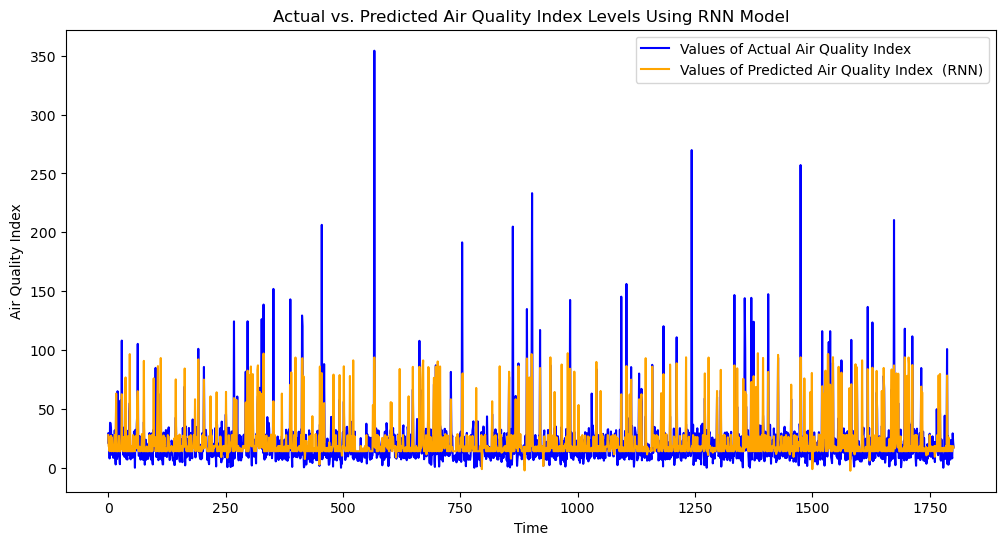

In [99]:
# Predections
y_pred_scaled_RNN = model_RNN.predict(X_test_reshaped)
y_pred_RNN = scaler_y.inverse_transform(y_pred_scaled_RNN)

# Plotting the true vs. predicted values
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='Values of Actual Air Quality Index ', color='blue')
plt.plot(y_pred_RNN, label='Values of Predicted Air Quality Index  (RNN)', color='orange')
plt.title('Actual vs. Predicted Air Quality Index Levels Using RNN Model')
plt.xlabel('Time')
plt.ylabel('Air Quality Index')
plt.legend()
plt.show()

### Finding Classification values of RNN Model

In [100]:
# Defining AQI categories
def categorize_aqi_RNN(value):
    if value <= 50:
        return 0
    elif 51 <= value <= 100:
        return 1
    elif 101 <= value <= 150:
        return 2
    elif 151 <= value <= 200:
        return 3
    else:
        return 4

# Apply categorization to both true and predicted values
y_test_classified_RNN = y_test.apply(categorize_aqi_RNN)
y_pred_classified_RNN = pd.Series(y_pred_RNN.flatten()).apply(categorize_aqi_RNN)

### Printing all the classificaction values

In [101]:
#printing all the calculated metrics.
accuracy_RNN = accuracy_score(y_test_classified_RNN, y_pred_classified_RNN)
print(f'Accuracy: {accuracy_RNN}')

precision_RNN = precision_score(y_test_classified_RNN, y_pred_classified_RNN, average='weighted')
print(f'Precision: {precision_RNN}')

recall_RNN = recall_score(y_test_classified_RNN, y_pred_classified_RNN, average='weighted')
print(f'Recall: {recall_RNN}')

f1_RNN = f1_score(y_test_classified_RNN, y_pred_classified_RNN, average='weighted')
print(f'F1 Score: {f1_RNN}')

Accuracy: 0.9339622641509434
Precision: 0.9499219649628409
Recall: 0.9339622641509434
F1 Score: 0.9371806659436511


/Users/bobby/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Reshaping the Data for Hybrid CNN-LSTM Model

In [102]:
# Reshape the input data to be 3D (samples, timesteps, features) if not already done
X_train_reshaped_Hybrid = np.expand_dims(X_train.values, axis=2)
X_val_reshaped_Hybrid = np.expand_dims(X_val.values, axis=2)
X_test_reshaped_Hybrid = np.expand_dims(X_test.values, axis=2)

### Hybrid CNN-LSTM Model Selection

In [103]:
# Define the hybrid CNN-LSTM model
hybrid_model_CNN_LSTM = Sequential()

# Add a 1D convolutional layer to capture spatial features
hybrid_model_CNN_LSTM.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train_reshaped.shape[1], 1)))
# Adjust the pool_size or padding to avoid negative dimension size
hybrid_model_CNN_LSTM.add(MaxPooling1D(pool_size=1))

In [104]:
# Add LSTM layers to capture temporal patterns
hybrid_model_CNN_LSTM.add(LSTM(50, return_sequences=True))
hybrid_model_CNN_LSTM.add(Dropout(0.2))
hybrid_model_CNN_LSTM.add(LSTM(50, return_sequences=False))
hybrid_model_CNN_LSTM.add(Dropout(0.2))

# Add a Dense layer for output
hybrid_model_CNN_LSTM.add(Dense(1))

# Compile the model
hybrid_model_CNN_LSTM.compile(optimizer='adam', loss='mean_squared_error')

### Training the Model

In [105]:
# Train the model
history_CNN_LSTM = hybrid_model_CNN_LSTM.fit(X_train_reshaped_Hybrid, y_train, epochs=100, batch_size=32, validation_data=(X_val_reshaped, y_val))

Epoch 1/100
451/451 [==============================] - 2s 1ms/step - loss: 683.6682 - val_loss: 401.4204
Epoch 2/100
451/451 [==============================] - 0s 900us/step - loss: 592.0717 - val_loss: 403.8974
Epoch 3/100
451/451 [==============================] - 0s 895us/step - loss: 591.3470 - val_loss: 404.2671
Epoch 4/100
451/451 [==============================] - 0s 894us/step - loss: 592.2650 - val_loss: 403.5266
Epoch 5/100
451/451 [==============================] - 0s 888us/step - loss: 593.5387 - val_loss: 402.7867
Epoch 6/100
451/451 [==============================] - 0s 888us/step - loss: 592.1644 - val_loss: 402.9527
Epoch 7/100
451/451 [==============================] - 0s 889us/step - loss: 591.3099 - val_loss: 402.4165
Epoch 8/100
451/451 [==============================] - 0s 891us/step - loss: 591.2624 - val_loss: 403.5871
Epoch 9/100
451/451 [==============================] - 0s 894us/step - loss: 591.6188 - val_loss: 402.9446
Epoch 10/100
451/451 [=================

### Model Predection & Evaluation

In [106]:
# Make predictions on the test set
y_pred_hybrid_CNN_LSTM = hybrid_model_CNN_LSTM.predict(X_test_reshaped_Hybrid)

# Calculate metrics
mse_hybrid_CNN_LSTM = mean_squared_error(y_test, y_pred_hybrid_CNN_LSTM)
rmse_hybrid_CNN_LSTM = np.sqrt(mse_hybrid_CNN_LSTM)
mae_hybrid_CNN_LSTM = mean_absolute_error(y_test, y_pred_hybrid_CNN_LSTM)

print(f'Hybrid Model - MSE: {mse_hybrid_CNN_LSTM}, RMSE: {rmse_hybrid_CNN_LSTM}, MAE: {mae_hybrid_CNN_LSTM}')
print(y_pred_hybrid_CNN_LSTM)

57/57 [==============================] - 0s 438us/step
Hybrid Model - MSE: 391.4794750169991, RMSE: 19.785840265629336, MAE: 9.15669054891108
[[25.566517]
 [18.36396 ]
 [18.404877]
 ...
 [18.374834]
 [18.381443]
 [18.11391 ]]


### Visualising the Model predection

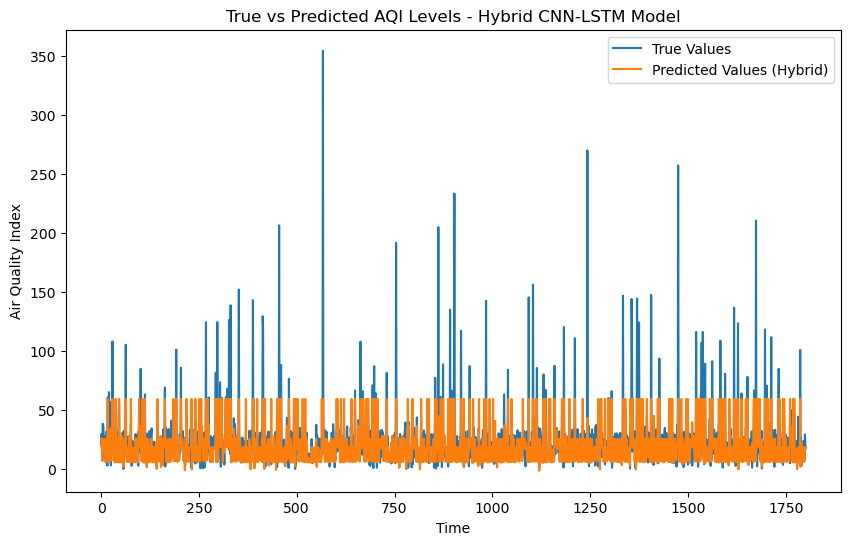

In [107]:
# Plot the true values vs predicted values for the hybrid model
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='True Values')
plt.plot(y_pred_hybrid_CNN_LSTM, label='Predicted Values (Hybrid)')
plt.xlabel('Time')
plt.ylabel('Air Quality Index')
plt.title('True vs Predicted AQI Levels - Hybrid CNN-LSTM Model')
plt.legend()
plt.show()


### Finding and Printing Classification values of Hybrid CNN-LSTM Model

In [108]:
# Define AQI categories (adjust the ranges based on your AQI standards)
def categorize_aqi_CNN_LSTM(value):
    if value <= 50:
        return 0  # Good
    elif 51 <= value <= 100:
        return 1  # Moderate
    elif 101 <= value <= 150:
        return 2  # Unhealthy for Sensitive Groups
    elif 151 <= value <= 200:
        return 3  # Unhealthy
    else:
        return 4  # Very Unhealthy

# Apply categorization to both true and predicted values
y_test_classified_CNN_LSTM = y_test.apply(categorize_aqi_CNN_LSTM)
y_pred_classified_CNN_LSTM = pd.Series(y_pred_hybrid_CNN_LSTM.flatten()).apply(categorize_aqi_CNN_LSTM)

In [109]:
accuracy_CNN_LSTM = accuracy_score(y_test_classified_CNN_LSTM, y_pred_classified_CNN_LSTM)
print(f'Accuracy: {accuracy_CNN_LSTM}')

precision_CNN_LSTM = precision_score(y_test_classified_CNN_LSTM, y_pred_classified_CNN_LSTM, average='weighted')
print(f'Precision: {precision_CNN_LSTM}')

recall_CNN_LSTM = recall_score(y_test_classified_CNN_LSTM, y_pred_classified_CNN_LSTM, average='weighted')
print(f'Recall: {recall_CNN_LSTM}')

f1_CNN_LSTM = f1_score(y_test_classified_CNN_LSTM, y_pred_classified_CNN_LSTM, average='weighted')
print(f'F1 Score: {f1_CNN_LSTM}')

Accuracy: 0.91842397336293
Precision: 0.9482987149946114
Recall: 0.91842397336293
F1 Score: 0.9272729927691579


/Users/bobby/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [110]:
# Performance metrics for the RNN model
rnn_metrics = {'Accuracy': accuracy_RNN,'Precision': precision_RNN,'Recall': recall_RNN,'F1 Score': f1_RNN}

# Performance metrics for the Hybrid CNN-LSTM model
cnn_lstm_metrics = {'Accuracy': accuracy_CNN_LSTM,'Precision': precision_CNN_LSTM,'Recall': recall_CNN_LSTM,
                    'F1 Score': f1_CNN_LSTM}


### Validating the Performance of Both Models.

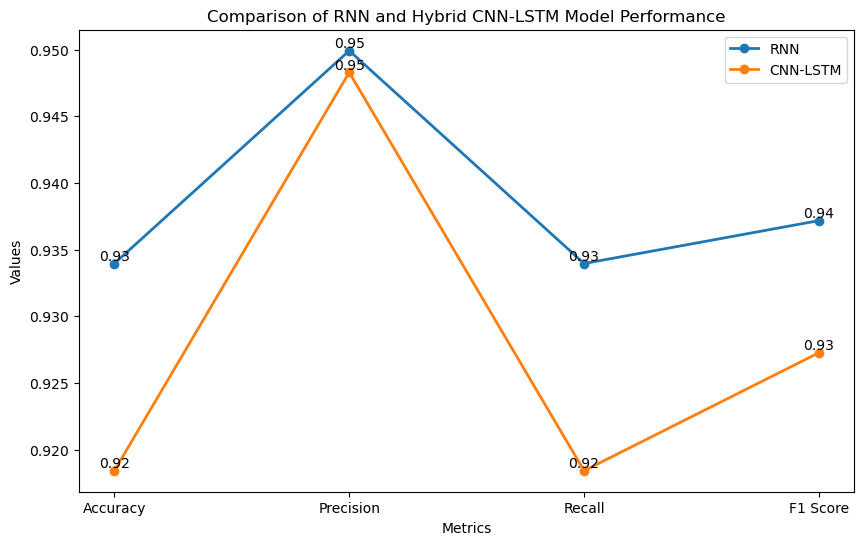

In [111]:
# Define the metric names
metrics_RNN_Hybrid = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

# Values for each model
rnn_values_RNN_Hybrid = [rnn_metrics[metric] for metric in metrics_RNN_Hybrid]
cnn_lstm_values_RNN_Hybrid = [cnn_lstm_metrics[metric] for metric in metrics_RNN_Hybrid]

# Set the width of the bars and positions
x_RNN_Hybrid = np.arange(len(metrics_RNN_Hybrid))

# Plotting the bar chart
fig, ax = plt.subplots(figsize=(10, 6))
Line1_RNN_Hybrid = ax.plot(x_RNN_Hybrid, rnn_values_RNN_Hybrid, marker='o', linestyle='-', label='RNN', linewidth=2)
Line2_RNN_Hybrid = ax.plot(x_RNN_Hybrid, cnn_lstm_values_RNN_Hybrid, marker='o', linestyle='-', label='CNN-LSTM', linewidth=2)


# Add labels and title
ax.set_xlabel('Metrics')
ax.set_ylabel('Values')
ax.set_title('Comparison of RNN and Hybrid CNN-LSTM Model Performance')
ax.set_xticks(x_RNN_Hybrid)
ax.set_xticklabels(metrics_RNN_Hybrid)
ax.legend()

# Display values on top of the bars
def add_values(x, y, ax):
    for i in range(len(x)):
        ax.text(x[i], y[i], f'{y[i]:.2f}', ha='center', va='bottom')

add_values(x_RNN_Hybrid, rnn_values_RNN_Hybrid, ax)
add_values(x_RNN_Hybrid, cnn_lstm_values_RNN_Hybrid, ax)
plt.show()



### Future Predection

In [112]:
# Number of future time steps to predict
future_steps = 50

# Use the last available data points from X_test for prediction
last_sequence = X_test_reshaped[-1].reshape(1, X_test_reshaped.shape[1], 1)

# List to store future predictions
future_predictions = []

for _ in range(future_steps):
    next_pred = hybrid_model_CNN_LSTM.predict(last_sequence)[0][0]
    future_predictions.append(next_pred)

    # Update last_sequence with the new prediction (shift left and add the new prediction)
    # Reshape next_pred to match the dimensions of last_sequence[:, 1:, :]
    next_pred_reshaped = next_pred.reshape(1, 1, 1)  # Reshape to (1, 1, 1)
    new_sequence = np.concatenate([last_sequence[:, 1:, :], next_pred_reshaped], axis=1)
    last_sequence = new_sequence

1/1 [==============================] - 0s 8ms/step


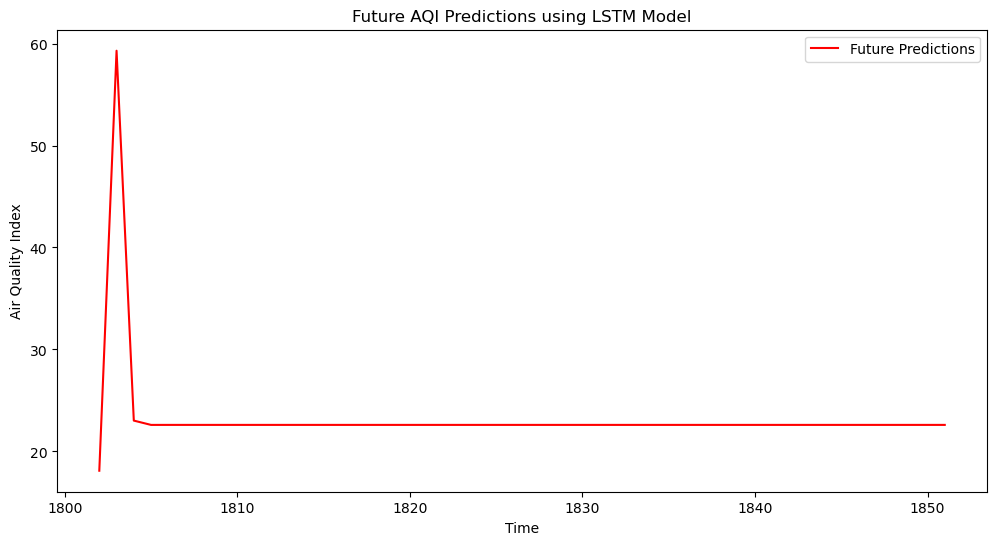

In [115]:
# Plot the future predictions
plt.figure(figsize=(12, 6))
# plt.plot(range(len(y_test)), y_test.values, label='Historical AQI', color='blue')
# plt.plot(range(len(y_test)), y_pred, label='Predicted Historical AQI (LSTM)', color='orange')
plt.plot(range(len(y_test), len(y_test) + future_steps), future_predictions, label='Future Predictions', color='red')
plt.title('Future AQI Predictions using LSTM Model')
plt.xlabel('Time')
plt.ylabel('Air Quality Index')
plt.legend()
plt.show()